# Figure Generation

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import seaborn as sns
import matplotlib.pylab as plt
import bites as bt
from os import sep
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation
from IPython.display import HTML, display

In [2]:
plt.rcParams['pdf.fonttype'] = 42

Extract data directory and metadata. 

In [3]:
dataDir = 'raw/JK_biting_paper_trained_data_04092025'
metaDat = 'video_parameters_04172025.csv'
plot_folder = r"plots/"

In [4]:
datasetDf = pd.read_csv(sep.join([dataDir, metaDat])).rename(columns={'Unnamed: 0': 'video'})
datasetDf['path'] = datasetDf['video'].apply(lambda x: sep.join([dataDir, x.replace('vid', dataDir.split(sep)[-1].split('_')[-1])]))
datasetDf['filename'] = datasetDf['video'].apply(lambda x: x.replace('vid','data')+'.csv')
datasetDf['videofile'] = datasetDf['video'].apply(lambda x: x+'.mp4')

In [5]:
undDf = pd.read_csv(sep.join([dataDir.split('/')[0], 'underskin_data.csv']))
undDfFull = pd.read_csv(sep.join([dataDir.split('/')[0], 'underskin_data_full.csv']))

Specify video index.

In [36]:
videoIdx = 4

In [37]:
vid_folder = datasetDf['path'].iloc[videoIdx]
filename = datasetDf['filename'].iloc[videoIdx]
vidfile = datasetDf['videofile'].iloc[videoIdx]
legDf = pd.read_csv(sep.join([vid_folder,filename]),header=[1,2],index_col=0)
voltageDf = undDf[['Time [s]', datasetDf['sync_name'].iloc[videoIdx], datasetDf['sync_name'].iloc[videoIdx]+'_cond']].dropna().rename(columns={datasetDf['sync_name'].iloc[videoIdx]: 'Voltage [V]', datasetDf['sync_name'].iloc[videoIdx]+'_cond': 'condition'}).copy()
camera_fps = datasetDf['Frame rate (fps)'].iloc[videoIdx] #camera fps
n = len(legDf)
T = n/camera_fps

Derive a dataframe that centers the coordinates relative to the labium and uses the movement of the labium to classify bites. 


In [38]:
derDf = bt.derive(legDf, T)

In [39]:
corrDf = pd.DataFrame(index=legDf.index, columns=['bite'])
corrDf['bite'] = derDf['bite']
corrDf['time [s]'] = legDf.index/camera_fps
corrDf['insert_length'] = bt.computeForAllBites(derDf, bt.insert_length)
corrDf['straightness'] = bt.computeForAllBites(derDf, bt.straightness)
corrDf['lab_angle'] = bt.computePerBite(derDf, bt.estimate_3d_labial_twist, r=1.25, segment =2)
corrDf['pal_angle'] = bt.computePerBite(derDf, bt.estimate_3d_palp_angle, r=1.2, segment=2)
corrDf['dPh'] = bt.computeForAllBites(corrDf, bt.deltaPhase)
if np.any(['gut' in derDf.columns.values[l][0] for l in range(len(derDf.columns.values))]):
    corrDf['gl'] = bt.gut_length(derDf)

In [40]:
corrDf['removal'] = bt.computePerBite(corrDf, bt.straightness_motion, dir = 'removal', filts = [50, 50, 251], threshold_netchange=0.01)
corrDf['insertion'] = bt.computePerBite(corrDf, bt.straightness_motion,  dir = 'insertion', filts = [75, 50, 251], threshold_netchange=0.01)
corrDf['removal'] = corrDf['removal'].interpolate(method='nearest', limit_direction='both')
corrDf['insertion'] = corrDf['insertion'].interpolate(method='nearest', limit_direction='both')

In [41]:
parts = ('tar1','tar2','tar3','lab1','lab2','lab3','pal1','pal2','pal3')

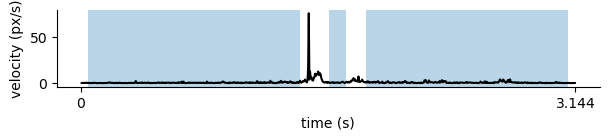

In [42]:
plt.figure(figsize=(7, 1))

# Plot the raw velocity and bite signal
plt.plot(derDf['ctr_speed'], color='k')

# Add colored patches for each segment where corrDf['bite'] > 0
for i in range(len(corrDf['bite'])):
    val = corrDf['bite'].iloc[i]
    if val > 0:
        # Optional: choose color based on value
        plt.axvspan(i - 0.5, i + 0.5, alpha=0.3)

sns.despine()
plt.xticks([0, n], [0, T])
plt.xlabel('time (s)')
plt.ylabel('velocity (px/s)')

# Save the figure
plt.savefig(plot_folder + f"panel_{videoIdx}_" + "bite_segmentation.pdf", bbox_inches="tight")

## Moving to Labium Frame

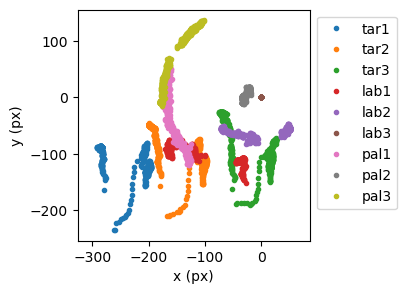

In [43]:
plt.figure(figsize = (3,3))
plt.axes().set_aspect('equal');
plt.plot(derDf.loc[:,(parts,('x'))].values,
         derDf.loc[:,(parts,('y'))].values,'.');
plt.axis('equal')
plt.legend(list(parts),bbox_to_anchor = (1,1));
plt.xlabel('x (px)'); plt.ylabel('y (px)');
plt.savefig(plot_folder+f"panel_{videoIdx}_"+"bodyparts_labium_frame_xy.pdf",bbox_inches = "tight")

In [44]:
# Load the video
video = bt.videoExtract(sep.join([vid_folder, vidfile]))

## Panels

/Users/chitniss/anaconda3/lib/python3.11/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


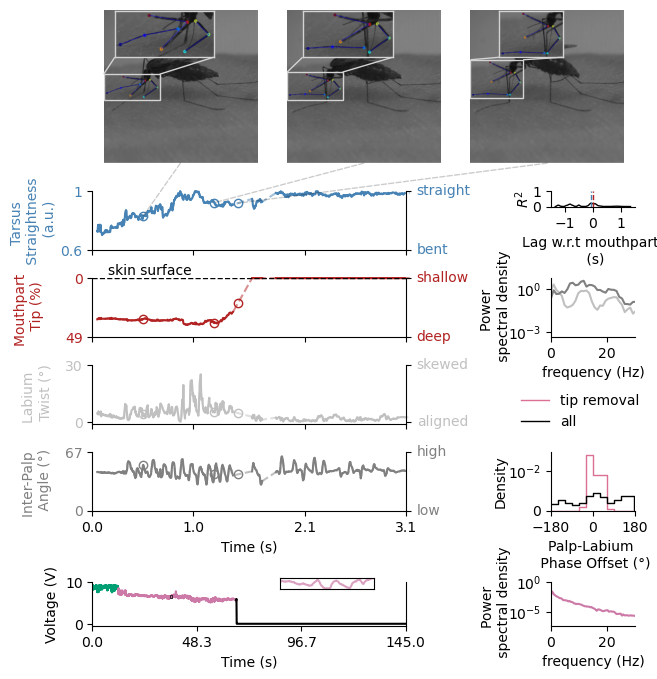

In [45]:
# === Color Settings ===
colors = {
    'insert': 'firebrick',
    'gut': 'rosybrown',
    'straight': 'steelblue',
    'twist': 'silver',
    'palp': 'grey',
    'trace': 'powderblue',
    'piercing': '#0072b2',
    'feeding': '#009e73',
    'retracting': '#cc79a7',
    'searching': '#e69f00',
    'removed': 'black'

}
#get undDfFull mapped
undDfFull['colors'] = undDfFull['cond'].map(colors)

fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(12, 12, width_ratios=[1]*12, height_ratios=[1]+[0.1]*9+[0.05]*2, hspace=1.1, wspace=0.2)

# === ax_insert: Mouthpart Insert Length ===
ax_insert = fig.add_subplot(gs[3:5, 0:7])
ax_insert.plot(corrDf['time [s]'], corrDf['insert_length'], color=colors['insert'], clip_on=False, zorder=-1)
ax_insert.plot(corrDf['time [s]'], corrDf['insert_length'].interpolate(), color=colors['insert'], clip_on=False, zorder=-1, linestyle='--', alpha=0.5)
ax_insert.set_ylabel("Mouthpart \n Tip (%)", fontsize=10, color=colors['insert'], labelpad=15)
ax_insert.text(0.05, 1.05, "skin surface", fontsize=10, color='k', transform = ax_insert.transAxes)
ax_insert.set_xlim(0, np.round(T,1))
ax_insert.set_ylim(np.min(corrDf['insert_length'])-0.1,  0)
ax_insert.set_yticks([np.min(corrDf['insert_length'])-0.1, 0])
ax_insert.axhline(y=0, xmax=1, color='black', linewidth=1, linestyle='--')
ax_insert.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
ax_insert.set_xticklabels([])


frame_indices = datasetDf[['frame1','frame2','frame3']].iloc[videoIdx].values
frame_times = frame_indices * T/n

def mark_open_circles(ax, y_data, color):
    for t in frame_times:
        idx = np.argmin(np.abs(corrDf['time [s]'] - t))
        ax.plot(corrDf['time [s]'].values[idx], y_data[idx], marker='o', color=color, fillstyle='none', linewidth=1, clip_on=False, zorder = 10)

def other_side_ticks(ax, labels, color, side ="R", padding=0.035):
    if side=="R": 
        ax.tick_params(axis='y', labelright=False, left=True, right=True, labelleft=True)
        pad = 1+padding
    elif side=="L":
        ax.tick_params(axis='y', labelright=True, left=True, right=True, labelleft=False)
        pad = -padding
    for t, tick in enumerate(ax.get_yticks()):
        ax.annotate(labels[t], 
                            xy=(pad, tick), 
                            xycoords=('axes fraction', 'data'),
                            va='center', ha='left' if side=="R" else 'right', color = color)

mark_open_circles(ax_insert, corrDf['insert_length'].interpolate(), colors['insert'])

# === ax_straight: Tarsus Straightness ===
ax_straight = fig.add_subplot(gs[1:3, 0:7])
ax_straight.plot(corrDf['time [s]'], corrDf['straightness'], color=colors['straight'], clip_on=False)
ax_straight.plot(corrDf['time [s]'], corrDf['straightness'].interpolate(), color=colors['straight'], clip_on=False, zorder=-5, linestyle='--', alpha=0.5)
ax_straight.set_ylabel("Tarsus \n Straightness \n (a.u.)", fontsize=10, color=colors['straight'], labelpad=3)
ax_straight.set_ylim(corrDf['straightness'].min()-0.1, 1)
ax_straight.set_yticks([corrDf['straightness'].min()-0.1, 1])
ax_straight.set_xlim(0, np.round(T, 1))
ax_straight.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
ax_straight.set_xticklabels([])
sns.despine(ax=ax_straight, bottom=False, right = False, left = False)
ax_straight.set_yticklabels([np.round(corrDf['straightness'].min()-0.1,1), 1], color=colors['straight'])
other_side_ticks(ax_straight, ['bent', 'straight'], colors['straight'], side='R')
mark_open_circles(ax_straight, corrDf['straightness'].interpolate(), colors['straight'])

# === ax_twist: Labium Twist ===
ax_twist = fig.add_subplot(gs[5:7, 0:7])
ax_twist.plot(corrDf['time [s]'], corrDf['lab_angle'], color=colors['twist'], linestyle='-', clip_on=False)
ax_twist.plot(corrDf['time [s]'], corrDf['lab_angle'].interpolate(), color=colors['twist'], linestyle='--', clip_on=False, alpha=0.5, zorder=-5)
ax_twist.set_ylabel("Labium \n Twist (°)", fontsize=10, color=colors['twist'], labelpad=9)
ax_twist.set_xlim(0, np.round(T, 1)) #np.round(T,1))
ax_twist.set_ylim(-1, corrDf['lab_angle'].max()+5)
ax_twist.set_yticks([0, corrDf['lab_angle'].max()+5])
ax_twist.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
ax_twist.set_xticklabels([])
sns.despine(ax=ax_twist, bottom=False, right = False, left = False)
ax_twist.set_yticklabels([0,  int(np.round(corrDf['lab_angle'].max()+5))], color=colors['twist'])
other_side_ticks(ax_twist, ['aligned', 'skewed'], colors['twist'], side='R')
mark_open_circles(ax_twist, corrDf['lab_angle'].interpolate(), colors['twist'])

# === Gut Length (Overlay) ===
if 'gl' in corrDf.columns:
    print("Gut length data found, adding to plot.")
    ax_gut = ax_insert.twinx()
    ax_gut.plot(corrDf['time [s]'], corrDf['gl'], color=colors['gut'], alpha=0.5, clip_on=False, zorder=-5)
    ax_gut.set_ylim(0.5, 2)
    ax_gut.set_yticks([1, 1.5])
    mark_open_circles(ax_gut, corrDf['gl'], colors['gut'])
    sns.despine(ax=ax_gut, bottom=True, right=False, left=False)
    ax_gut.set_yticklabels(['small', 'large'], color=colors['gut'], zorder=10)
    ax_gut.yaxis.set_label_position("left")
    ax_gut.set_ylabel("Gut Size (%)", fontsize=10, color=colors['gut'], labelpad=25)
    ax_insert.set_ylabel("Mouthpart \n Tip (%)", fontsize=10, color=colors['insert'], labelpad=22)
    other_side_ticks(ax_gut, [100, 150], colors['gut'], side='L')


# === ax_insert: Mouthpart Insertion Depth ===
sns.despine(ax=ax_insert, bottom=False, right = False, left = False)
ax_insert.set_yticklabels([int(100*np.round(np.abs(np.min(corrDf['insert_length'])-0.1),2)), 0], color=colors['insert'])
other_side_ticks(ax_insert, ['deep', 'shallow'], colors['insert'], side='R')

# === ax_palp: Inter-Palp Angle ===
ax_palp = fig.add_subplot(gs[7:9, 0:7])
ax_palp.plot(corrDf['time [s]'], corrDf['pal_angle'], color=colors['palp'], clip_on=False, linestyle='-')
ax_palp.plot(corrDf['time [s]'], corrDf['pal_angle'].interpolate(), color=colors['palp'], clip_on=False, linestyle='--', alpha=0.5, zorder=-5)
ax_palp.set_ylabel("Inter-Palp \n Angle (°)", fontsize=10, color=colors['palp'], labelpad=9)
ax_palp.set_xlim(0, np.round(T, 1))
ax_palp.set_ylim(0, corrDf['pal_angle'].max()+5)
ax_palp.set_yticks([0, corrDf['pal_angle'].max()+5])
ax_palp.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
ax_palp.set_xlabel('Time (s)', fontsize=10)
sns.despine(ax=ax_palp, bottom=False, right = False, left = False)
ax_palp.set_yticklabels([0, int(np.round(corrDf['pal_angle'].max()+5))], color=colors['palp'])
other_side_ticks(ax_palp, ['low', 'high'], colors['palp'], side='R')
mark_open_circles(ax_palp, corrDf['pal_angle'].interpolate(), colors['palp'])

# === Correlation Plot ===
limits = (-1.5, 1.5)
ax_str_ins = fig.add_subplot(gs[1, 10:])
ax_str_ins.set_xlim(limits[0], limits[1])
ax_str_ins.set_ylim(0, 1)
lags, r_sq = bt.get_lag_curve(corrDf)
#filter by limits
r_sq = r_sq[(lags >= limits[0]) & (lags <= limits[1])]
lags = lags[(lags >= limits[0]) & (lags <= limits[1])]
lag_at_max_corr = lags[np.argmax(r_sq)] if np.max(r_sq) > 0.1 else 0
ax_str_ins.plot(lags, r_sq, color='k', linewidth=1)
ax_str_ins.set_xlabel('Lag w.r.t mouthpart \n (s)', fontsize=10)
ax_str_ins.set_ylabel('$R^2$', labelpad=0)
ax_str_ins.axvline(x=lag_at_max_corr, color=colors['straight'], linestyle='--', linewidth=1)
ax_str_ins.axvline(x=0, color=colors['insert'], linestyle='--', linewidth=1)
sns.despine(ax=ax_str_ins)

ax_pal_lab = fig.add_subplot(gs[7:9, 10:])
min_val = -181
max_val = 181
bin_width = 30
bins = list(range(min_val, max_val + bin_width, bin_width))
if corrDf['removal'].sum() > 0:
    sns.histplot(corrDf.loc[corrDf['removal'].astype(bool), 'dPh'], bins=bins, ax=ax_pal_lab, element="step", stat="density", fill=False, color='palevioletred', linewidth=1, label='tip removal')
if corrDf['insertion'].sum() > 0:
    sns.histplot(corrDf.loc[corrDf['insertion'].astype(bool), 'dPh'], bins=bins, ax=ax_pal_lab, element="step", stat="density", fill=False, color='darkmagenta', linewidth=1, label='tip insertion')
sns.histplot(corrDf['dPh'], bins=bins, ax=ax_pal_lab, element="step", stat="density", fill=False, color='k', linewidth=1, label='all')
if (corrDf['removal'].sum() > 0) | (corrDf['insertion'].sum() > 0):
    ax_pal_lab.legend(loc='upper right', bbox_to_anchor=(1.2, 2.2), fontsize=10, frameon=False)
else:
    ax_pal_lab.legend([], [], frameon=False)
ax_pal_lab.set_xlabel('Palp-Labium \n Phase Offset (°)', fontsize=10)
ax_pal_lab.set_xlim(-181, 181)
ax_pal_lab.set_xticks([-180, 0, 180])
ax_pal_lab.set_yticks([0, 0.01])
ax_pal_lab.set_ylim([0, None])
ax_pal_lab.set_yticklabels([0]+[r'$10^{'+f'{int(np.log10(y))}'+r'}$' for y in [0.01]])
ax_pal_lab.set_ylabel('Density', fontsize=10, labelpad=0)
sns.despine(ax=ax_pal_lab)

# === Power Spectrum ===
ax_spec = fig.add_subplot(gs[3:5, 10:]) if ((corrDf['removal'].sum() > 0) | (corrDf['insertion'].sum() > 0)) else fig.add_subplot(gs[3:6, 10:])
f, Pxx_den = signal.welch(corrDf['lab_angle'].dropna(), fs=n/T)
f1, Pxx_den1 = signal.welch(corrDf['pal_angle'].dropna(), fs=n/T)
ax_spec.semilogy(f, Pxx_den, color=colors['twist'], linewidth=1.5)
ax_spec.semilogy(f1, Pxx_den1, color=colors['palp'], linewidth=1.5)
ax_spec.set_xlabel('frequency (Hz)')
ax_spec.set_yticks([0.001, 1])
ax_spec.set_xlim(0, 30)
ax_spec.set_ylabel('Power \n spectral density', fontsize=10, labelpad=-2
                   )
sns.despine(ax=ax_spec)

# === Inset for Active Movements ===

try:
    removal = bt.zoom_str_mot(corrDf, zoomInterval=0.75, which=2)
except:
    removal = bt.zoom_str_mot(corrDf, zoomInterval=0.75, which=1)
insertion = bt.zoom_str_mot(corrDf, zoomInterval=0.75, event='insertion')
toplot = removal if removal.sum() > 0 else insertion if insertion.sum() > 0 else None
if (T > 8) & (toplot is not None):
    for ax, col, key, anchor in [(ax_palp, 'palp', 'pal_angle', 0), (ax_twist, 'twist', 'lab_angle', 0.1)]:
        t_start = corrDf['time [s]'][toplot].min()
        t_end = corrDf['time [s]'][toplot].max()
        ax_in = inset_axes(ax, width="30%", height="20%", bbox_to_anchor=(0.6, anchor, 1, 1), bbox_transform=ax.transAxes, loc='upper left', borderpad=0)
        ax_in.plot(corrDf['time [s]'][toplot], corrDf[key][toplot], color=colors[col], alpha=0.7)
        ax_in.set_xlim(t_start, t_end)
        ax_in.set_ylim(corrDf[key][toplot].min(), corrDf[key][toplot].max())
        ax_in.set_xticks([]); ax_in.set_yticks([])
        ax_in.set_facecolor('white')
        [s.set_edgecolor('palevioletred') for s in ax_in.spines.values()] if removal.sum() > 0 else [s.set_edgecolor('darkmagenta') for s in ax_in.spines.values()]
        ax.axvspan(t_start, t_end, ymin=(v0:=corrDf[key][toplot].min()-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                             ymax=(v1:=corrDf[key][toplot].max()-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                             fill=False, edgecolor='palevioletred' if removal.sum() > 0 else 'darkmagenta', linewidth=1, zorder=10)

# === Video Stills with Insets ===
for i, (t, frame) in enumerate(zip(frame_times, frame_indices)):
    ax_vid = fig.add_subplot(gs[0, 4*i:4*(i+1)])
    ax_vid.imshow(video[frame])
    ax_vid.axis('off')
    idx = np.argmin(np.abs(corrDf['time [s]'] - t))
    partslist = tuple(pd.Series(parts)[pd.Series(parts).str.contains('lab|pal|tar')].tolist())
    x1 = legDf.loc[idx, (partslist, 'x')].min() - 20
    x2 = legDf.loc[idx, (partslist, 'x')].max() + 20
    y1 = legDf.loc[idx, (partslist, 'y')].min() - 20
    y2 = legDf.loc[idx, (partslist, 'y')].max() + 20
    axins = inset_axes(ax_vid, width='75%', height='30%', loc='upper left', bbox_to_anchor=[0.02, -0.01, 1, 1], bbox_transform=ax_vid.transAxes, borderpad=0)
    axins.imshow(video[frame])
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_facecolor('lightgrey')
    for spine in axins.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)
    mark_inset(ax_vid, axins, loc1=3, loc2=4, fc="none", ec="lightgrey", lw=1, zorder=0)
    con = ConnectionPatch(xyA=(len(video[0])//2, len(video[0])),
                          xyB=(t, corrDf['straightness'].interpolate()[frame]), coordsB=ax_straight.transData,
                          axesA=ax_vid, axesB=ax_straight, coordsA=ax_vid.transData,
                          color='k', linewidth=1, linestyle='--', alpha=0.2)
    fig.add_artist(con)

# === Underskin Plot ===
voltageDf['colors'] = voltageDf['condition'].map(colors)
grouped = voltageDf.groupby('colors')
ax_und = fig.add_subplot(gs[10:, 0:7])
for key, group in grouped:
    group.plot(ax=ax_und, x="Time [s]", y="Voltage [V]", label=key, color=key, legend=None)
ax_und.set_xlabel('Time (s)', fontsize=10)
ax_und.set_ylabel('Voltage (V)', fontsize=10)
sns.despine(ax=ax_und, bottom=False, right=False, left=False)
ax_und.set_ylim(None, 10)
ax_und.set_yticks([np.round(voltageDf['Voltage [V]'].min()), 10])
ax_und.set_xlim(0, np.round(voltageDf['Time [s]'].max(),2))
ax_und.set_xticks(np.round(np.linspace(0, np.round(voltageDf['Time [s]'].max(), 1), 4), 1))

# === Power Spectrum Under Skin ===
ax_spec_und = fig.add_subplot(gs[10:, 10:]) 
fund, Pxx_den_und = signal.welch(voltageDf.loc[voltageDf['condition']==voltageDf['condition'].loc[voltageDf['condition']!='removed'].mode().values[0], 'Voltage [V]'].values, fs=len(voltageDf)/voltageDf['Time [s]'].max())
ax_spec_und.semilogy(fund, Pxx_den_und, color=voltageDf['colors'].loc[voltageDf['condition']!='removed'].mode().values[0], linewidth=1.5)
ax_spec_und.set_xlabel('frequency (Hz)')
ax_spec_und.set_yticks([0.00001, 1])
ax_spec_und.set_xlim(0, 30)
ax_spec_und.set_ylabel('Power \n spectral density', fontsize=10, labelpad=-2)
sns.despine(ax=ax_spec_und)

if voltageDf['Time [s]'].max() > 100:
    t_center = voltageDf['Time [s]'].mean()/2
    t_start = t_center - 0.5
    t_end = t_center + 0.5

    # Time window mask
    window_mask = (voltageDf['Time [s]'] >= t_start) & (voltageDf['Time [s]'] <= t_end)

    # Inset axis anchored above ax_und
    ax_in = inset_axes(ax_und, width="30%", height="25%",
                       bbox_to_anchor=(0.6, 0.1, 1, 1),
                       bbox_transform=ax_und.transAxes,
                       loc='upper left', borderpad=0)

    # Plot voltage trace in the inset
    ax_in.plot(voltageDf['Time [s]'][window_mask],
               voltageDf['Voltage [V]'][window_mask],
               color=voltageDf['colors'].loc[voltageDf['condition']!='removed'].mode().values[0], alpha=0.7)

    # Configure inset appearance
    ax_in.set_xlim(t_start, t_end)
    ax_in.set_ylim(voltageDf['Voltage [V]'][window_mask].min(),
                   voltageDf['Voltage [V]'][window_mask].max())
    ax_in.set_xticks([]); ax_in.set_yticks([])
    ax_in.set_facecolor('white')

    # Set spine color depending on removal
    [s.set_edgecolor('k') for s in ax_in.spines.values()]

    # Mark region on the main plot (ax_und)
    ymin = voltageDf['Voltage [V]'][window_mask].min()
    ymax = voltageDf['Voltage [V]'][window_mask].max()
    v0 = (ymin - ax_und.get_ylim()[0]) / (ax_und.get_ylim()[1] - ax_und.get_ylim()[0])
    v1 = (ymax - ax_und.get_ylim()[0]) / (ax_und.get_ylim()[1] - ax_und.get_ylim()[0])

    ax_und.axvspan(t_start, t_end, ymin=v0, ymax=v1,
                   fill=False,
                   edgecolor='k',
                   linewidth=0.5, zorder=10)

# === Save Figure ===
plt.savefig(plot_folder + f"panel_{videoIdx}.pdf", bbox_inches='tight', dpi=300)

In [46]:
oversave= True

In [49]:
playbackspeed = 0.25#x

# --- Setup ---
colors = {
    'insert': 'firebrick',
    'gut': 'rosybrown',
    'straight': 'steelblue',
    'twist': 'silver',
    'palp': 'grey'
}

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(14, 2, width_ratios=[1.25, 2], height_ratios=[0.1]*13+[0.3], hspace=30, wspace=0.3)

# === Video frame (left side: rows 0-9, columns 0-4) ===
ax_vid = fig.add_subplot(gs[:10, 0])
ax_vid.set_title(f'{playbackspeed}x speed', fontsize=10)
im = ax_vid.imshow(video[0])
ax_vid.axis('off')

# === Time-Series Axes (right side: columns 5-11) ===
# Tarsus Straightness
ax_straight = fig.add_subplot(gs[1:3, 1])
line_straight, = ax_straight.plot([], [], color=colors['straight'], clip_on=False, zorder=-10)
line_straight2, = ax_straight.plot([], [], color=colors['straight'], clip_on=False, linestyle='--', zorder=-10)

ax_straight.set_ylabel("Tarsus \n Straightness \n (a.u.)", fontsize=10, color=colors['straight'], labelpad=3)
ax_straight.set_ylim(corrDf['straightness'].min()-0.1, 1)
ax_straight.set_yticks([corrDf['straightness'].min()-0.1, 1])
ax_straight.set_xlim(0, np.round(T, 1))
ax_straight.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
ax_straight.set_xticklabels([])
sns.despine(ax=ax_straight, bottom=False, right = False, left = False)
ax_straight.set_yticklabels([np.round(corrDf['straightness'].min()-0.1,1), 1], color=colors['straight'])
other_side_ticks(ax_straight, ['bent', 'straight'], colors['straight'], side='R')
ax_straight.set_title(f'{playbackspeed}x speed', fontsize=10, loc='left')

# Mouthpart Insertion
ax_insert = fig.add_subplot(gs[3:5, 1])
line_insert, = ax_insert.plot([], [], color=colors['insert'], clip_on=False, zorder = -10)
line_insert2, = ax_insert.plot([], [], color=colors['insert'], clip_on=False, linestyle='--', alpha=0.5, zorder=-10)
ax_insert.set_ylabel("Mouthpart \n Tip (%)", fontsize=10, color=colors['insert'], labelpad=15)
ax_insert.text(0.05, 1.05, "skin surface", fontsize=10, color='k', transform = ax_insert.transAxes)
ax_insert.set_xlim(0, np.round(T,1))
ax_insert.set_ylim(np.min(corrDf['insert_length'])-0.1,  0)
ax_insert.set_yticks([np.min(corrDf['insert_length'])-0.1, 0])
ax_insert.axhline(y=0, xmax=1, color='black', linewidth=1, linestyle='--')
ax_insert.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
ax_insert.set_xticklabels([])
ax_insert.set_yticklabels([int(100*np.round(np.abs(np.min(corrDf['insert_length'])-0.1),2)), 0], color=colors['insert'])

# Labium Twist
ax_twist = fig.add_subplot(gs[5:7, 1])
line_twist, = ax_twist.plot([], [], color=colors['twist'], linestyle='-', clip_on=False, zorder=-10)
line_twist2, = ax_twist.plot([], [], color=colors['twist'], linestyle='--', alpha=0.5, zorder=-10)
ax_twist.set_ylabel("Labium \n Twist (°)", fontsize=10, color=colors['twist'], labelpad=9)
ax_twist.set_xlim(0, np.round(T, 1)) #np.round(T,1))
ax_twist.set_ylim(-1, corrDf['lab_angle'].max()+5)
ax_twist.set_yticks([0, corrDf['lab_angle'].max()+5])
ax_twist.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
sns.despine(ax=ax_twist, bottom=False, right = False, left = False)
ax_twist.set_yticklabels([0,  int(np.round(corrDf['lab_angle'].max()+5))], color=colors['twist'])
ax_twist.set_xticklabels([])
other_side_ticks(ax_twist, ['aligned', 'skewed'], colors['twist'], side='R')

#Inter-Palp Angle
ax_palp = fig.add_subplot(gs[7:9, 1])
line_palp, = ax_palp.plot([], [], color=colors['palp'], linestyle='-', clip_on=False, zorder=-10)
line_palp2, = ax_palp.plot([], [], color=colors['palp'], linestyle='--', alpha=0.5, zorder=-10)
ax_palp.set_ylabel("Inter-Palp \n Angle (°)", fontsize=10, color=colors['palp'], labelpad=9)
ax_palp.set_xlim(0, np.round(T, 1))
ax_palp.set_ylim(0, corrDf['pal_angle'].max()+5)
ax_palp.set_yticks([0, corrDf['pal_angle'].max()+5])
ax_palp.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
sns.despine(ax=ax_palp, bottom=False, right = False, left = False)
ax_palp.set_yticklabels([0, int(np.round(corrDf['pal_angle'].max()+5))], color=colors['palp'])
ax_palp.set_xlabel('Time (s)', fontsize=10)
other_side_ticks(ax_palp, ['low', 'high'], colors['palp'], side='R')


# Optional Gut Length (shares y-axis with insert)
# Optional Gut Length if available
has_gut = 'gl' in corrDf.columns
if has_gut:
    ax_gut = ax_insert.twinx()
    line_gut, = ax_gut.plot([], [], color=colors['gut'], alpha=0.5, clip_on=False, zorder=-10)
    line_gut2, = ax_gut.plot([], [], color=colors['gut'], alpha=0.5, linestyle='--', zorder=-10)
    ax_gut.set_ylim(0.5, 2)
    ax_gut.set_yticks([1, 1.5])
    sns.despine(ax=ax_gut, bottom=True, right=False, left=False)
    ax_gut.set_yticklabels(['  small', '  large'], color=colors['gut'], zorder=10)
    ax_gut.yaxis.set_label_position("left")
    ax_gut.set_ylabel("Gut Size (%)", fontsize=10, color=colors['gut'], labelpad=25)
    other_side_ticks(ax_gut, [100, 150], colors['gut'], side='L', padding = 0.015)
    ax_insert.set_ylabel("Mouthpart \n Tip (%)", fontsize=10, color=colors['insert'], labelpad=22)


# === Underskin Plot ===
ax_und = fig.add_subplot(gs[12:, 1])
line_und, = ax_und.plot([], [], color = voltageDf['colors'].iloc[0] )
ax_und.set_xlabel('Time (s)', fontsize=10)
ax_und.set_ylabel('Voltage (V)', fontsize=10)
sns.despine(ax=ax_und, bottom=False, right=False, left=False)
ax_und.set_yticks([np.round(voltageDf['Voltage [V]'].min()), 10])
ax_und.set_xlim(0, np.round(voltageDf['Time [s]'].max(),2))
ax_und.set_xticks(np.round(np.linspace(0, np.round(voltageDf['Time [s]'].max(), 1), 4), 1))
ax_und.set_title(f"{np.round(playbackspeed*(voltageDf['Time [s]'].max()/corrDf['time [s]'].max()), 2)}x speed", fontsize=10, loc='left')

sns.despine(ax=ax_insert, bottom=False, right = False, left = False)
other_side_ticks(ax_insert, ['deep', 'shallow'], colors['insert'], side='R')

# Data
time = corrDf['time [s]']
y_insert = corrDf['insert_length']
y_insert_interp = corrDf['insert_length'].interpolate()
y_straight = corrDf['straightness']
y_straight_interp = corrDf['straightness'].interpolate()
y_twist = corrDf['lab_angle']
y_twist_interp = corrDf['lab_angle'].interpolate()
y_palp = corrDf['pal_angle']
y_palp_interp = corrDf['pal_angle'].interpolate()
if has_gut:
    y_gut = corrDf['gl']
    y_gut_interp = corrDf['gl'].interpolate()

voltageDf['color_index'] = voltageDf['colors'].astype('category').cat.codes
time_und = np.linspace(voltageDf['Time [s]'].iloc[0], voltageDf['Time [s]'].iloc[-1], len(time))
y_voltage = sp.interpolate.interp1d(voltageDf['Time [s]'], voltageDf['Voltage [V]'], kind='linear', 
                                    fill_value='extrapolate')(time_und)
y_color = sp.interpolate.interp1d(voltageDf['Time [s]'], voltageDf['color_index'], 
                                  kind='nearest', fill_value='extrapolate')(time_und)
y_color_str = voltageDf['colors'].astype('category').cat.categories[y_color.astype(int)].values

from matplotlib.collections import LineCollection

# Prepare segments and colors for LineCollection
points = np.array([time_und, y_voltage]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors_hex = y_color_str[:-1]  # drop last to match segments

# Create LineCollection
lc = LineCollection(segments, colors=colors_hex, linewidth=1)
ax_und.add_collection(lc)
ax_und.set_ylim(voltageDf['Voltage [V]'].min()-0.1, 10)

# create schematic
ax_schematic = fig.add_subplot(gs[11:, 0])
change = (undDfFull['colors'] != undDfFull['colors'].shift()).cumsum()
groups = list(undDfFull.groupby(change))
box = datasetDf.loc[videoIdx, ['box_0', 'box_1']].values
texts = ['Surface piercing', 'Blood vessel \n searching', 'Blood \n ingestion', 'Mouthpart \n retraction', 'Mouthpart \n withdrawal']
locs = [[40, 0], [30, 3], [100, 4], [150, 3], [170, 0]]
sub = undDfFull.query(f'{box[0]} <= `Time [s]` <= {box[1]}')
for i, (_, g) in enumerate(groups): ax_schematic.plot(g['Time [s]'], g['Voltage [V]'], c:=g['colors'].iloc[0]); i>0 and ax_schematic.plot([groups[i-1][1]['Time [s]'].iloc[-1], g['Time [s]'].iloc[0]], [groups[i-1][1]['Voltage [V]'].iloc[-1], g['Voltage [V]'].iloc[0]], color=c); i < len(locs) and ax_schematic.text(*locs[i], texts[i], fontsize=8, color=c, ha='center')
ymin, ymax = sub['Voltage [V]'].min(), sub['Voltage [V]'].max(); 
ax_schematic.hlines([ymin, ymax], *box, linestyles='dashed', colors='k', linewidth=0.5); 
ax_schematic.vlines(box, ymin, ymax, linestyles='dashed', colors='k', linewidth=0.5);
ax_schematic.set_xlabel("Time (s)"); ax_schematic.set_ylabel("Voltage (V)"); sns.despine(ax=ax_schematic);

# Build a vector of data indices, one per animation frame
step = int(playbackspeed*8)
base_idx = np.arange(0, len(time), step)
pad_frames = int(5 * len(base_idx) / (T / playbackspeed))
data_idx = np.concatenate([base_idx, np.full(pad_frames, len(time)-1, dtype=int)])

def animate(frame_num):
    i = int(data_idx[frame_num])  # map frame -> data index
    i = min(i, len(time)-1)       # clamp, and now [:i+1] grabs the full point i
    im.set_array(video[i])
    j = i + 1                      # inclusive slice for full point i

    line_insert.set_data(time[:j], y_insert[:j])
    line_insert2.set_data(time[:j], y_insert_interp[:j])
    line_straight.set_data(time[:j], y_straight[:j])
    line_straight2.set_data(time[:j], y_straight_interp[:j])
    line_palp.set_data(time[:j], y_palp[:j])
    line_palp2.set_data(time[:j], y_palp_interp[:j])
    line_twist.set_data(time[:j], y_twist[:j])
    line_twist2.set_data(time[:j], y_twist_interp[:j])
    if has_gut:
        line_gut.set_data(time[:j], y_gut[:j])
        line_gut2.set_data(time[:j], y_gut_interp[:j])

    lc.set_segments(segments[:j-1])          # segments are between points
    lc.set_color(colors_hex[:j-1])           # keep lengths matched

    return [
        im, line_insert, line_insert2, line_straight, line_straight2,
        line_palp, line_palp2, line_twist, line_twist2,
        *( [line_gut, line_gut2] if has_gut else [] ),
        lc
    ]

ani = animation.FuncAnimation(
    fig, animate,
    frames=range(len(data_idx)),
    interval=(step)*T/n*1000/playbackspeed,  # whatever your timing formula is
    repeat=False
)

fig.add_artist(plt.Line2D([0.1, 0.9], [0.3, 0.3], color='black', linewidth=1, linestyle = '--', transform=fig.transFigure))
fig.text(0.15, 0.32, 'Above skin', fontsize=10, ha='center', color = 'k', va='center', transform=fig.transFigure)
fig.text(0.15, 0.28, 'Below skin', fontsize=10, ha='center', color = 'k', va='center', transform=fig.transFigure)

html = HTML(ani.to_html5_video())
display(html)
plt.close()

# === Display in Notebook ===
if oversave:
    ani.save(plot_folder + f"panel_{videoIdx}_playback_{playbackspeed}x.mp4", fps=n/(T*5)*playbackspeed, dpi=500, extra_args=['-vcodec', 'libx264'])

In [34]:
1+1

2

## Supplementary Plots

In [18]:
expDf = pd.DataFrame()
for videoIdxI in range(len(datasetDf)):
    corrDf = bt.corrDfConstruct(videoIdxI, datasetDf, phase='late', phase_time = 1.2).copy()
    corrDf['videoIdx'] = videoIdxI
    expDf = pd.concat([expDf, corrDf], axis=0).reset_index(drop=True)

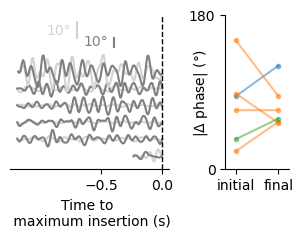

In [19]:
from scipy.signal import butter, filtfilt, hilbert
fig, ax = plt.subplots(1,2,figsize=(3.6, 2), gridspec_kw={'width_ratios': [1, 0.4], 'wspace': 0.5})
condition = 'insertion'
mask = expDf[condition] == 1
groups = (mask != mask.shift()).cumsum()
removal_blocks = expDf[mask].groupby(groups[mask])

for bi, block in removal_blocks:
    block = block[['time [s]', 'lab_angle', 'pal_angle', 'videoIdx']].dropna(axis=0, how='any').copy()
    t_rel = block['time [s]'].values -block['time [s]'].values[-1]  # align to end
    fs = 1/np.median(np.diff(block['time [s]'].values))
    dp1 = bt.apply_bandpass_filter(block['lab_angle'], 5, 20, fs=fs, order = 4)
    dp2 = bt.apply_bandpass_filter(block['pal_angle'], 5, 20, fs=fs, order = 4)
    ax[0].plot(t_rel, dp1*2+bi*10, color='lightgrey')
    ax[0].plot(t_rel, dp2+bi*10, color='grey')
    ax[1].plot([0,1], [np.mean((np.rad2deg(np.abs(((np.angle(hilbert(dp1))-np.angle(hilbert(dp2)))-np.pi)%(2*np.pi)-np.pi))[t_rel<t_rel.min()+0.15])),
np.mean((np.rad2deg(np.abs(((np.angle(hilbert(dp1))-np.angle(hilbert(dp2)))-np.pi)%(2*np.pi)-np.pi)))[t_rel>-0.15])],
    '.-', color = block['videoIdx'].map(lambda x: f"C{x}").values[0], alpha=0.5)


ax[0].plot([-0.4, -0.4], [(len(removal_blocks)*2.5)*10, (len(removal_blocks)*2.5+1)*10], color='grey', linewidth=1.5)
ax[0].plot([-0.7, -0.7], [(len(removal_blocks)*2.5+1)*10, (len(removal_blocks)*2.5+3)*10], color='lightgrey', linewidth=1.5)
ax[0].text(-0.95, (len(removal_blocks)*2.5+1.5)*10, '10°', color='lightgrey')
ax[0].text(-0.65, (len(removal_blocks)*2.5+0.25)*10, '10°', color='grey')
ax[0].axvline(0, color='k', linestyle='--', linewidth=1)
ax[0].set_xticks([-0.5, 0])
ax[1].set_xticks([0, 1])
ax[1].set_xlim([-0.25, 1.25])
ax[1].set_yticks([0, 180])
ax[1].set_xticklabels(['initial', 'final'])
ax[1].set_ylabel(r'$|\Delta$ phase| (°)', fontsize=10, labelpad=-15)

ax[0].set_yticks([])
ax[0].set_ylabel(None)
ax[0].set_xlabel(f'Time to \n maximum {condition.replace("removal", "withdrawal")} (s)')
sns.despine(left=True, ax=ax[0])
sns.despine(ax=ax[1])
plt.savefig(plot_folder + f'{condition}'+"_phase_shift.pdf", bbox_inches='tight', dpi=300)